In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

### load pre-cleaned data

In [6]:
data = pd.read_csv("../Josh/AvgEnergyWeather.csv")
# these are either null, or unnecessary (Unamed)
data = data.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'Unnamed: 0', 'weather_id'])
# drop all datapoints that have all their values as null
data = data.dropna(how='all')
# drop datapoints that have less than 20 NON-null values
data = data.dropna(thresh=20)
data = data.fillna(data.mean())
assert sum(data.isnull().sum()) == 0

In [32]:
data_no_gen_avg.columns

Index(['forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all'],
      dtype='object')

In [11]:
data_w = pd.read_csv("../Josh/WeightedAvgEnergyWeather.csv")
# these are either null, or unnecessary (Unamed)
data_w = data_w.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'Unnamed: 0', 'weather_id'])
# drop all datapoints that have all their values as null
data_w = data_w.dropna(how='all')
# drop datapoints that have less than 20 NON-null values
data_w = data_w.dropna(thresh=20)
data_w = data_w.fillna(data.mean())
assert sum(data_w.isnull().sum()) == 0

In [14]:
data_no_gen_avg = data[[col for col in data.columns if col[:10] != 'generation']]

In [15]:
data_no_gen_w_avg = data_w[[col for col in data_w.columns if col[:10] != 'generation']]

### Try new cleaning to include times

In [143]:
energy = pd.read_csv('../../data/energy_dataset.csv')
weather = pd.read_csv('../../data/weather_features.csv')

In [144]:
weather = weather.drop(columns=['weather_id', 'weather_icon'])

In [145]:
weather_main_dummies = pd.get_dummies(weather.weather_main)
weather = weather.drop(columns=['weather_main', 'weather_description']).join(weather_main_dummies)

In [519]:
weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,clear,clouds,drizzle,dust,fog,haze,mist,rain,smoke,snow,squall,thunderstorm
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [146]:
total = pd.DataFrame()

for name in weather.city_name.unique():
    cityData = weather.loc[weather.city_name == name]
    dfn = pd.merge(energy, cityData, left_on='time', right_on='dt_iso')
    dfn=dfn.drop_duplicates("time")
    dfn = dfn.set_index("time")
    if(not(total.empty)):
        total+=dfn
    else:
        total=dfn
    print(total.shape)

(35064, 53)
(35064, 53)
(35064, 53)
(35064, 53)
(35064, 53)


In [147]:
total['weather_main'] = total[['clear', 'clouds', 'drizzle', 'dust', 'fog', 'haze',
       'mist', 'rain', 'smoke', 'snow', 'squall', 'thunderstorm']].idxmax(axis=1)
total = total.drop(columns=['clear', 'clouds', 'drizzle', 'dust', 'fog', 'haze',
       'mist', 'rain', 'smoke', 'snow', 'squall', 'thunderstorm'])

# take average
def take_avg(col):
    if col.dtype != object:
        col /= 5
    return col

total = total.apply(take_avg)

In [166]:
total = total.drop(columns=['dt_iso', 'city_name'])

KeyError: "['dt_iso', 'city_name'] not found in axis"

In [167]:
total = total.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'])

## Feature Engineering:

- Convert seasonality features into sin-cosine transform

In [18]:
# Credit to: https://towardsdatascience.com/time-seasonality-features-in-time-series-7e8236f7b04a
def cyclic_transform(column):
    max_val = column.max()
    sine = [np.sin((2 * np.pi * i) / max_val) for i in list(column)]
    cosine = [np.cos((2 * np.pi * i) / max_val) for i in list(column)]
    return sine, cosine

## Vis

In [20]:
data_no_gen_avg

,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,17.000000,6436.000000,26118.000000,25385.000000,50.100000,65.410000,271.948543,271.948543,271.948543,1000.680199,76.734832,2.415786,183.951102,0.000000,0.0,0.0,0.000000
1,16.000000,5856.000000,24934.000000,24382.000000,48.100000,64.920000,271.954072,271.954072,271.954072,1000.628132,76.734832,2.415786,184.107305,0.000000,0.0,0.0,0.000000
2,8.000000,5454.000000,23515.000000,22734.000000,47.330000,64.480000,271.277437,271.277437,271.277437,1001.043767,76.918201,2.556897,160.092665,0.000000,0.0,0.0,0.000000
3,2.000000,5151.000000,22642.000000,21286.000000,42.270000,59.320000,271.274920,271.274920,271.274920,1000.991699,76.918201,2.556897,160.144733,0.000000,0.0,0.0,0.000000
4,9.000000,4861.000000,21785.000000,20264.000000,38.410000,56.040000,271.289611,271.289611,271.289611,1000.991699,76.918201,2.556897,159.936462,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,17.988379,5818.840930,25188.600815,25154.606399,55.414445,59.593026,282.058055,281.243873,282.965877,1014.117114,82.879113,4.306973,223.086327,0.432342,0.0,0.0,36.445065
35060,13.091760,6026.688651,25952.490643,25918.223363,57.480181,61.423157,281.674288,280.835029,282.639436,1013.991398,83.595835,4.108361,227.841232,0.144114,0.0,0.0,41.337911
35061,14.774525,6160.598702,27646.357682,27683.234380,60.061956,63.865118,281.277179,280.419544,282.245533,1013.991398,89.708874,4.293993,223.702234,0.144114,0.0,0.0,36.653335
35062,64.265620,6255.980984,28602.765318,28686.037881,60.774297,65.074778,280.882193,279.649245,281.970404,1013.991398,86.190009,4.034561,276.350740,0.144114,0.0,0.0,19.840024


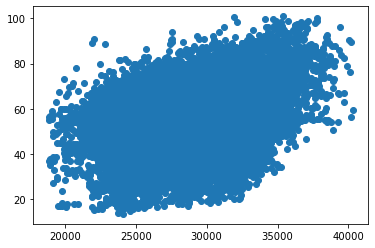

In [21]:
plt.scatter(data_no_gen_avg['total load actual'], data_no_gen_avg['price actual'])

<AxesSubplot:>

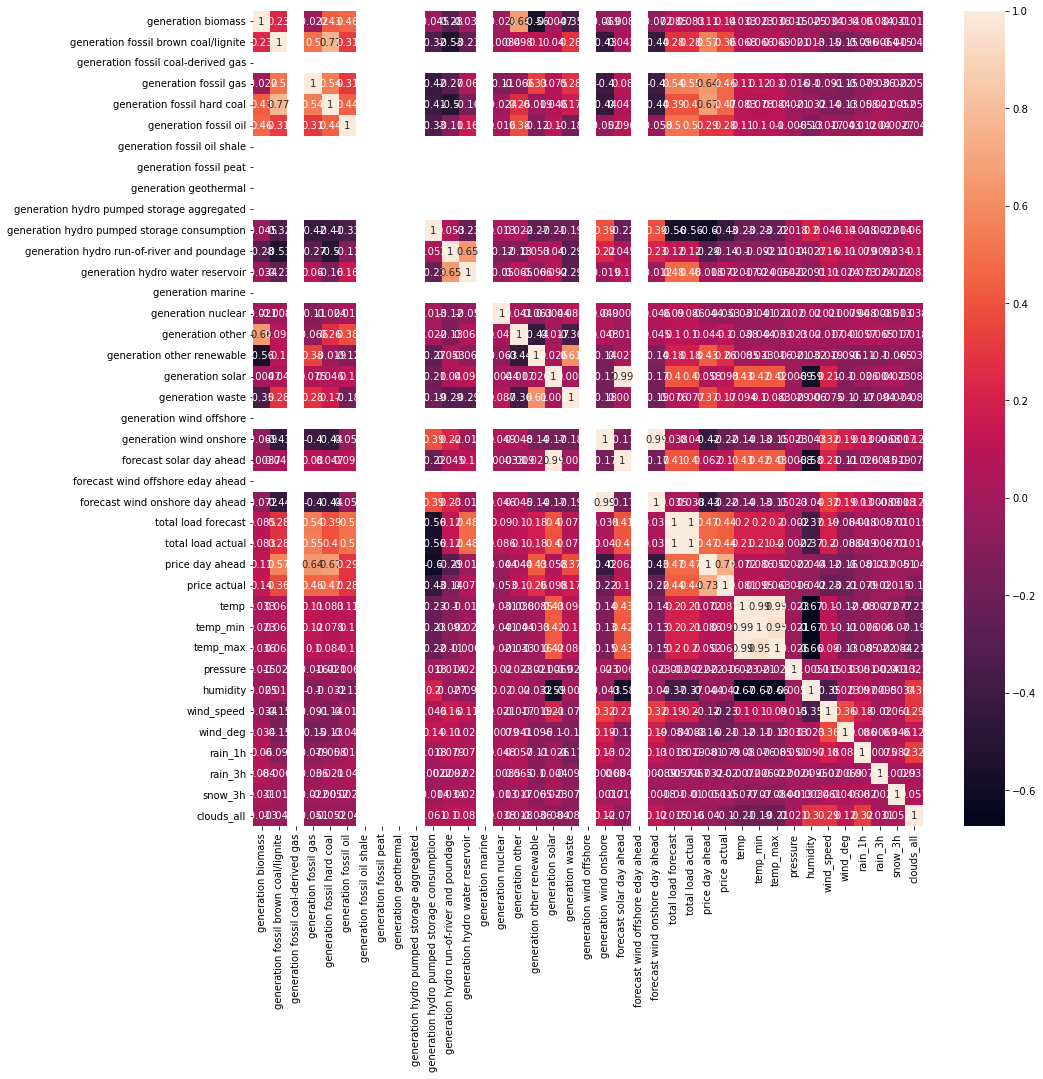

In [151]:
plt.figure(figsize=(15,15))
sns.heatmap(total.corr(), annot=True, fmt='.2g')

## Information Gain Feature Test

In [298]:
from sklearn.feature_selection import mutual_info_regression

In [299]:
pd.set_option('display.max_columns', 500)

In [300]:
use_for_fi = total.copy()
use_for_fi = pd.get_dummies(use_for_fi)

In [301]:
use_for_fi = use_for_fi.dropna()

In [302]:
use_for_fi.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'temp',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_main_clear', 'weather_main_clouds',

In [303]:
use_for_fi.index[0][5:7]

'01'

In [305]:
def parse_hour(item):
    hour = int(item[11:13])
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour <=17:
        return 'day'
    return 'night'
def parse_month(item):
    month = int(item[5:7])
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [306]:
use_for_fi = use_for_fi.reset_index()
use_for_fi['time_of_day'] = use_for_fi.time.apply(parse_hour)
use_for_fi['season'] = use_for_fi.time.apply(parse_month)

In [309]:
# OHe our new features
use_for_fi = use_for_fi.set_index('time')

In [311]:
use_for_fi = pd.get_dummies(use_for_fi)

In [314]:
use_for_fi.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'temp',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_main_clear', 'weather_main_clouds',

In [413]:
# feat_cols_more = ['generation biomass', 'generation fossil brown coal/lignite',
#        'generation fossil coal-derived gas', 'generation fossil gas',
#        'generation fossil hard coal', 'generation fossil oil',
#        'generation fossil oil shale', 'generation fossil peat',
#        'generation geothermal', 'generation hydro pumped storage consumption',
#        'generation hydro run-of-river and poundage',
#        'generation hydro water reservoir', 'generation marine',
#        'generation nuclear', 'generation other', 'generation other renewable',
#        'generation solar', 'generation waste', 'generation wind offshore',
#        'generation wind onshore', 'forecast solar day ahead',
#        'forecast wind onshore day ahead','temp',
#        'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
#        'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
#        'weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle',
#        'weather_main_fog', 'weather_main_mist', 'weather_main_rain',
#        'weather_main_thunderstorm']

feat_cols = ['temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle',
       'weather_main_fog', 'weather_main_mist', 'weather_main_rain',
       'weather_main_thunderstorm', 'time_of_day_day', 'time_of_day_morning',
       'time_of_day_night', 'season_fall', 'season_spring', 'season_summer',
       'season_winter']

feat_cols_more = feat_cols + ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead']

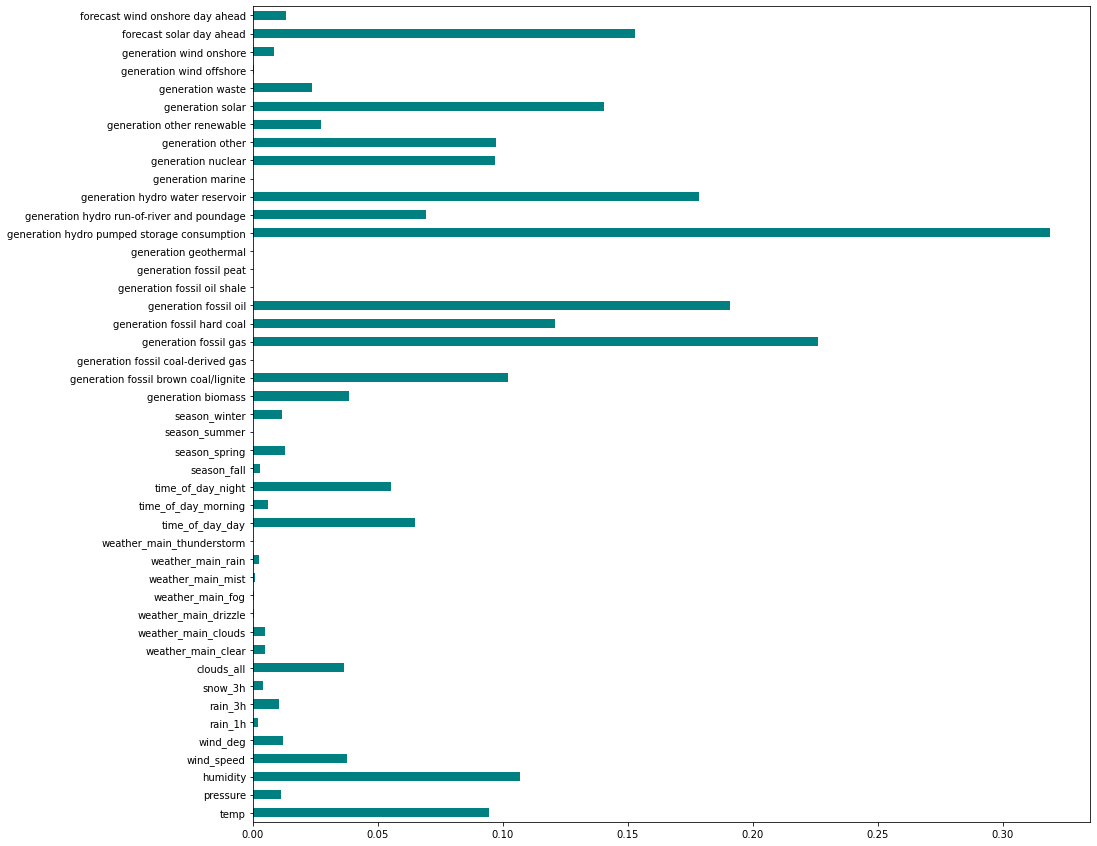

In [430]:
importances = mutual_info_regression(use_for_fi[feat_cols_more], use_for_fi['total load actual'])
feat_importances = pd.Series(importances, feat_cols_more)
plt.figure(figsize=(15,15))
feat_importances.plot(kind='barh', color='teal')
plt.show()

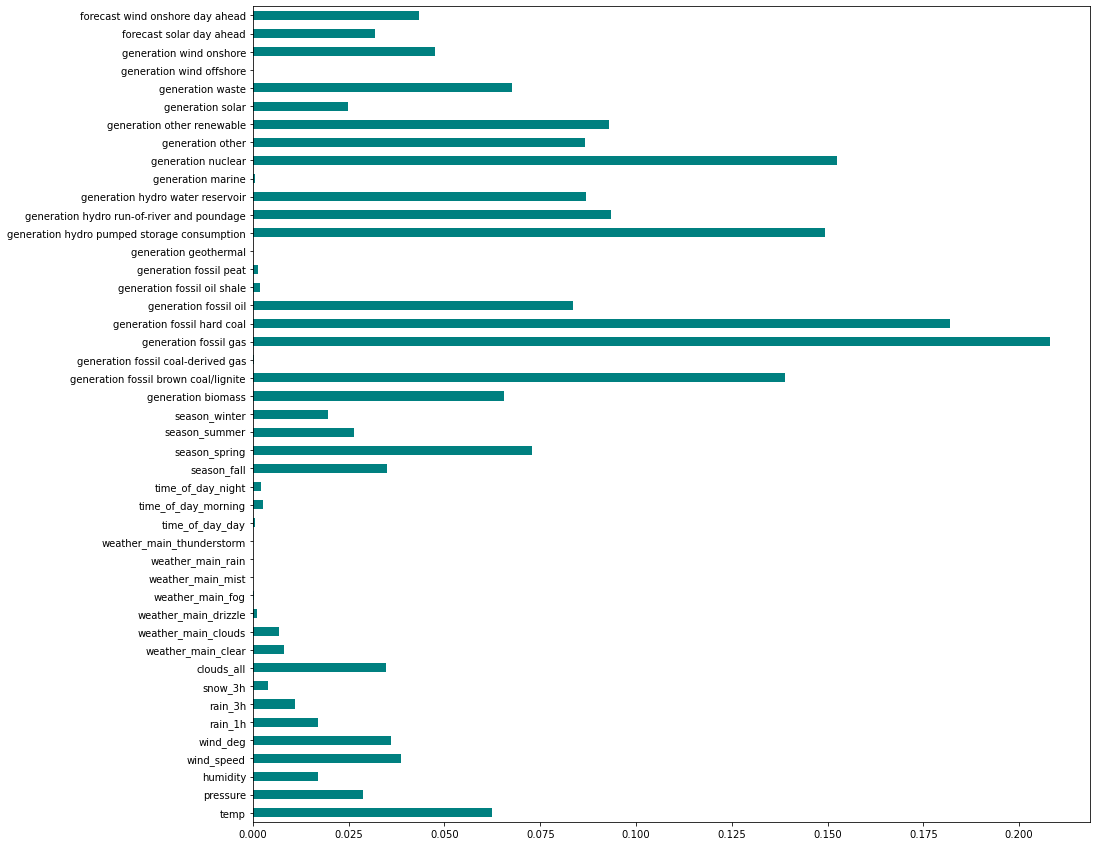

In [431]:
plt.figure(figsize=(15, 15))
importances = mutual_info_regression(use_for_fi[feat_cols_more], use_for_fi['price actual'])
feat_importances = pd.Series(importances, feat_cols_more)
feat_importances.plot(kind='barh', color='teal')
plt.show()

### Train XGBoost

In [456]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [490]:
subset = use_for_fi[feat_cols_more + ['total load actual']]

In [491]:
training, testing = train_test_split(subset, test_size=0.30)
training, testing = MinMaxScaler().fit_transform(training), MinMaxScaler().fit_transform(testing)

In [492]:
# X_train, y_train = training.to_numpy()[:, :-1], training.to_numpy()[:, -1]
# X_test, y_test = testing.to_numpy()[:, -1], testing.to_numpy()[:, -1]
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = testing[:, :-1], testing[:, -1]

In [493]:
model_xgb = xgboost.XGBRegressor(random_state=42, max_depth=10)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [494]:
model_xgb.feature_importances_

array([1.6930480e-03, 1.5431424e-03, 2.2238945e-03, 1.2297329e-03,
       1.0086893e-03, 1.7852221e-03, 1.5385202e-03, 2.9072640e-03,
       1.3112252e-03, 7.8101730e-04, 1.0890291e-03, 5.6367768e-05,
       0.0000000e+00, 3.3999004e-03, 2.0790962e-03, 1.3878899e-04,
       1.0136895e-02, 6.9645485e-03, 1.5611300e-02, 4.4665951e-03,
       5.3625652e-03, 1.9316304e-03, 1.2673823e-02, 2.7913060e-03,
       6.7037204e-03, 0.0000000e+00, 6.1463054e-02, 1.9484818e-02,
       7.4263498e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.5150015e-01, 1.9827183e-02, 4.9660783e-02, 0.0000000e+00,
       1.8153166e-02, 4.6026194e-03, 5.5103782e-03, 2.6796678e-02,
       5.4028630e-03, 0.0000000e+00, 4.7927026e-02, 9.3686633e-02,
       3.2293804e-02], dtype=float32)

### Scores

In [495]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [496]:
y_train_pred = model_xgb.predict(X_train)

In [497]:
mean_squared_error(y_train, y_train_pred)

3.872622988244217e-05

In [498]:
cross_val_score(model_xgb, X_train, y_train)

array([0.95231558, 0.95115677, 0.95518369, 0.94935634, 0.95376745])

In [499]:
r2_score(y_train, y_train_pred)

0.999029624496336

In [500]:
y_test_pred = model_xgb.predict(X_test)

In [501]:
mean_squared_error(y_test, y_test_pred)

0.009206364199711211

In [503]:
cross_val_score(model_xgb, X_test, y_test)

array([0.92814564, 0.92634062, 0.9260686 , 0.92496297, 0.92973771])

In [502]:
r2_score(y_test, y_test_pred)

0.7684291606507969

### Train XGBoost - Price

In [504]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [505]:
subset = use_for_fi[feat_cols_more + ['price actual']]

In [506]:
training, testing = train_test_split(subset, test_size=0.30)
training, testing = MinMaxScaler().fit_transform(training), MinMaxScaler().fit_transform(testing)

In [507]:
# X_train, y_train = training.to_numpy()[:, :-1], training.to_numpy()[:, -1]
# X_test, y_test = testing.to_numpy()[:, -1], testing.to_numpy()[:, -1]
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = testing[:, :-1], testing[:, -1]

In [508]:
model_xgb = xgboost.XGBRegressor(random_state=42, max_depth=10, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [509]:
model_xgb.feature_importances_

array([0.005772  , 0.00879323, 0.00372465, 0.02092969, 0.00369076,
       0.00765398, 0.00961732, 0.01043677, 0.00561152, 0.00319834,
       0.00537613, 0.        , 0.00180773, 0.00124744, 0.00548438,
       0.        , 0.00507434, 0.0036229 , 0.0147826 , 0.07736024,
       0.28701967, 0.0649225 , 0.02544782, 0.01152913, 0.01183698,
       0.        , 0.1177232 , 0.04311659, 0.01448257, 0.        ,
       0.        , 0.        , 0.03204555, 0.01941464, 0.03182772,
       0.        , 0.02075335, 0.02321634, 0.03807637, 0.00722747,
       0.01940094, 0.        , 0.00969359, 0.01545529, 0.01262628],
      dtype=float32)

### Scores

In [510]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [511]:
y_train_pred = model_xgb.predict(X_train)

In [512]:
mean_squared_error(y_train, y_train_pred)

0.00026834302648453905

In [514]:
cross_val_score(model_xgb, X_train, y_train)

array([0.88868969, 0.89372704, 0.88910176, 0.89142914, 0.8891578 ])

In [513]:
r2_score(y_train, y_train_pred)

0.9846041111966114

In [515]:
y_test_pred = model_xgb.predict(X_test)

In [516]:
mean_squared_error(y_test, y_test_pred)

0.006776825852562349

In [518]:
cross_val_score(model_xgb, X_test, y_test)

array([0.8260584 , 0.83492739, 0.83699976, 0.819822  , 0.83858742])

In [517]:
r2_score(y_test, y_test_pred)

0.6457050695258362